In [10]:
# True: Google Colab Notebook
# False: My local PC
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive/output/otto/
    base_path = '/content/drive/MyDrive'
    notebook_path = base_path + '/otto/notebook'
else:
    base_path = '../data'
    notebook_path = '.'

# Preprocessing

In [11]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools
import sys
sys.path.append(f"{notebook_path}/../src/")
import feature_engineering as fe

In [3]:
#test = pd.read_parquet('/content/drive/MyDrive/output/otto/test.parquet')
#test = pd.read_parquet(f'{base_path}/output/otto/test_50_tmp.parquet')
#test = pd.read_parquet(f'{base_path}/output/otto/test_50_0.parquet')
test = pd.read_parquet(f'{base_path}/output/otto/test_50_0_ver2.parquet')

In [4]:
# fileを分割して書き出す, 0 or 1
OUTPUT_SPLIT_NUM = 0
CROSS_TARGET_STACKING = True

In [22]:
output_session_splits = 4
min_val = test['session'].min()
max_val = test['session'].max()
print('OUTPUT_SPLIT_NUM=', OUTPUT_SPLIT_NUM)
print('original min session:', min_val, 'max_session:', max_val, 'shape:', test.shape)

output_session_splits_list = [int(min_val) + int(i*(max_val - min_val) / output_session_splits) for i in range(output_session_splits)]
print('output_session_splits=', output_session_splits)
print('output_session_splits_list=', output_session_splits_list)

if OUTPUT_SPLIT_NUM == output_session_splits - 1:
    test = test[output_session_splits_list[OUTPUT_SPLIT_NUM] <= test['session']]
else:
    test = test[(output_session_splits_list[OUTPUT_SPLIT_NUM] <= test['session']) & (test['session'] < output_session_splits_list[OUTPUT_SPLIT_NUM + 1])]

min_session, max_session = test['session'].min(), test['session'].max()
print('after min session:', min_session, 'max_session:', max_session, 'shape:', test.shape)

OUTPUT_SPLIT_NUM= 0
original min session: 12899779 max_session: 13317728 shape: (60321657, 175)
output_session_splits= 4
output_session_splits_list= [12899779, 13004266, 13108753, 13213240]
after min session: 12899779 max_session: 13004265 shape: (15274375, 175)


In [6]:
DEBUG_MODE = False
#DEBUG_MODE = True

if DEBUG_MODE:
    test = test.head(100000)
IGNORE_COL = ['session','aid']

#type_list = ['clicks', 'carts', 'orders']
#type_list = ['orders']
type_list = ['carts']

#TYPE_MODE = 'clicks'
#TYPE_MODE = 'carts'
#TYPE_MODE = 'orders'

session_path = f'{base_path}/output/otto/test_session_features.parquet'
aid_path = f'{base_path}/output/otto/test_aid_features.parquet'

In [23]:
# importanceが極端に低いものを削る (18件)
def remove_features(df):
    DROP_COL = ['session_type_mean']
    df = df.drop(DROP_COL, axis=1)
    return df

def add_cross_stacking_feature(df, target_list, min_session, max_session):
    split_num = 4
    stack_df = pd.DataFrame(columns=[], index = [])
    for t in target_list:
        for i in range(split_num):
            print('t=', t, 'i=', i)
            tmp_df = pd.read_parquet(f'{base_path}/otto/test_predictions_{t}_{i}_.parquet')
            tmp_df = tmp_df[(min_session <= tmp_df['session']) & (tmp_df['session'] <= max_session)]
            if i == 0:
                stack_df = tmp_df
            else:
                stack_df = pd.concat([stack_df, tmp_df])
            del tmp_df
            gc.collect()
        
        stack_df = stack_df.rename(columns={'score': f'pred_stack_{t}'})
        df = df.merge(stack_df, how='left', on=['session', 'aid'])
    del stack_df
    gc.collect()
    return df

In [8]:
test = fe.reduce_memory(test)

In [9]:
# join aid and session features
test = fe.join_session_features(test, session_path)
test = fe.join_aid_features(test, aid_path)
test = fe.join_interactive_features(test)
test = remove_features(test)

In [10]:
print('shape:', test.shape)
test

shape: (60321657, 175)


,session,aid,score_click,score_cart,score_buy,score_click_only,score_cart_only,score_buy_only,n_clicks_5,n_clicks_10,n_clicks_20,n_clicks_30,n_clicks_40,n_carts_5_ver0,n_carts_5_ver1,n_carts_15_ver0,n_carts_15_ver1,n_carts_20_ver0,n_carts_20_ver1,n_carts_30_ver0,n_carts_30_ver1,n_buys_5_ver0,n_buys_5_ver1,n_buys_15_ver0,n_buys_15_ver1,n_buys_20_ver0,n_buys_20_ver1,n_buys_30_ver0,n_buys_30_ver1,session_action_count,session_click_count,session_cart_count,session_order_count,session_last_type,session_first_action_ts_diff,session_last_action_ts_diff,session_ts_period,session_mean_action_ts_diff,session_unique_aid_action_count,session_unique_aid_click_count,session_unique_aid_cart_count,session_unique_aid_order_count,session_click_rate,session_cart_rate,session_order_rate,session_unique_aid_click_rate,session_unique_aid_cart_rate,session_unique_aid_order_rate,session_total_uu_action_ratio,session_clicks_uu_action_ratio,session_carts_uu_action_ratio,session_orders_uu_action_ratio,session_mean_aid_clicks_count_4weeks,session_mean_aid_carts_count_4weeks,session_mean_aid_orders_count_4weeks,session_mean_aid_total_count_4weeks,session_mean_aid_total_uu_4weeks,session_mean_aid_clicks_uu_4weeks,session_mean_aid_carts_uu_4weeks,session_mean_aid_orders_uu_4weeks,session_mean_aid_total_uu_action_ratio_4weeks,session_mean_aid_clicks_uu_action_ratio_4weeks,session_mean_aid_carts_uu_action_ratio_4weeks,session_mean_aid_orders_uu_action_ratio_4weeks,session_mean_aid_clicks_count_2weeks,session_mean_aid_carts_count_2weeks,session_mean_aid_orders_count_2weeks,session_mean_aid_total_count_2weeks,session_mean_aid_total_uu_2weeks,session_mean_aid_clicks_uu_2weeks,session_mean_aid_carts_uu_2weeks,session_mean_aid_orders_uu_2weeks,session_mean_aid_total_uu_action_ratio_2weeks,session_mean_aid_clicks_uu_action_ratio_2weeks,session_mean_aid_carts_uu_action_ratio_2weeks,session_mean_aid_orders_uu_action_ratio_2weeks,session_mean_aid_clicks_count_1week,session_mean_aid_carts_count_1week,session_mean_aid_orders_count_1week,session_mean_aid_total_count_1week,session_mean_aid_total_uu_1week,session_mean_aid_clicks_uu_1week,session_mean_aid_carts_uu_1week,session_mean_aid_orders_uu_1week,session_mean_aid_total_uu_action_ratio_1week,session_mean_aid_clicks_uu_action_ratio_1week,session_mean_aid_carts_uu_action_ratio_1week,session_mean_aid_orders_uu_action_ratio_1week,aid_clicks_count_4weeks,aid_carts_count_4weeks,aid_orders_count_4weeks,aid_total_count_4weeks,aid_total_uu_4weeks,aid_clicks_uu_4weeks,aid_carts_uu_4weeks,aid_orders_uu_4weeks,aid_total_uu_action_ratio_4weeks,aid_clicks_uu_action_ratio_4weeks,aid_carts_uu_action_ratio_4weeks,aid_orders_uu_action_ratio_4weeks,aid_clicks_rank_4weeks,aid_carts_rank_4weeks,aid_orders_rank_4weeks,aid_mean_session_action_count_4weeks,aid_mean_session_click_count_4weeks,aid_mean_session_cart_count_4weeks,aid_mean_session_order_count_4weeks,aid_mean_session_type_mean_4weeks,aid_clicks_count_2weeks,aid_carts_count_2weeks,aid_orders_count_2weeks,aid_total_count_2weeks,aid_total_uu_2weeks,aid_clicks_uu_2weeks,aid_carts_uu_2weeks,aid_orders_uu_2weeks,aid_total_uu_action_ratio_2weeks,aid_clicks_uu_action_ratio_2weeks,aid_carts_uu_action_ratio_2weeks,aid_orders_uu_action_ratio_2weeks,aid_clicks_rank_2weeks,aid_carts_rank_2weeks,aid_orders_rank_2weeks,aid_mean_session_action_count_2weeks,aid_mean_session_click_count_2weeks,aid_mean_session_cart_count_2weeks,aid_mean_session_order_count_2weeks,aid_mean_session_type_mean_2weeks,aid_clicks_count_1week,aid_carts_count_1week,aid_orders_count_1week,aid_total_count_1week,aid_total_uu_1week,aid_clicks_uu_1week,aid_carts_uu_1week,aid_orders_uu_1week,aid_total_uu_action_ratio_1week,aid_clicks_uu_action_ratio_1week,aid_carts_uu_action_ratio_1week,aid_orders_uu_action_ratio_1week,aid_clicks_rank_1week,aid_carts_rank_1week,aid_orders_rank_1week,aid_mean_session_action_count_1week,aid_mean_session_click_count_1week,aid_mean_session_cart_count_1week,aid_mean_session_order_count_1week,aid_mean_s

In [11]:
n_splits = 5
session_splits = 5

In [12]:
min_val = test['session'].min()
max_val = test['session'].max()
print('min session:', min_val, 'max_session:', max_val)

session_splits_list = [int(min_val) + int(i*(max_val - min_val) / session_splits) for i in range(session_splits)]
print('session_splits=', session_splits)
print('session_splits_list=', session_splits_list)

min session: 12899779 max_session: 13317728
session_splits= 5
session_splits_list= [12899779, 12983368, 13066958, 13150548, 13234138]


# Read Models

In [2]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

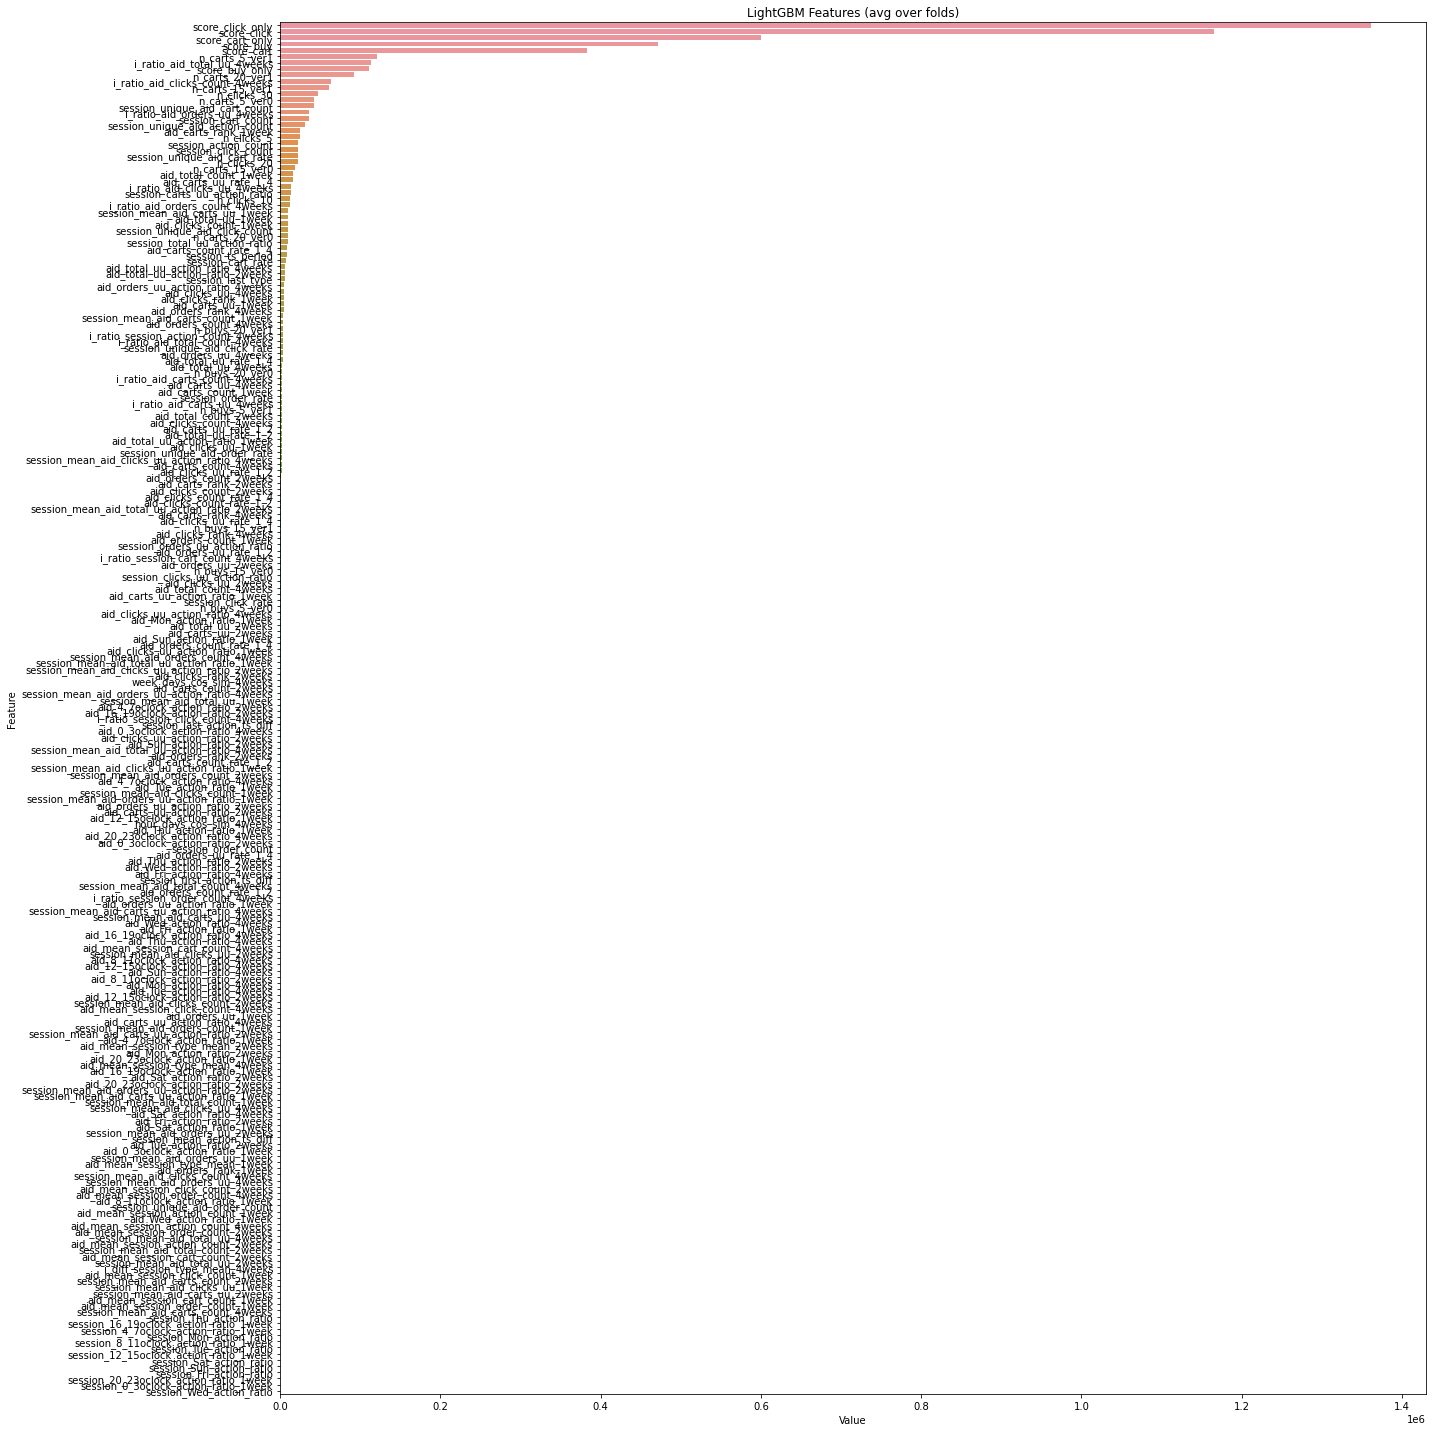

In [12]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)
model = np.load(f'{base_path}/otto/otto_lgbm_fold0_orders.pkl', allow_pickle=True)
#model = np.load(f'{base_path}/otto/backup/otto_lgbm_fold0_orders.pkl', allow_pickle=True)


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

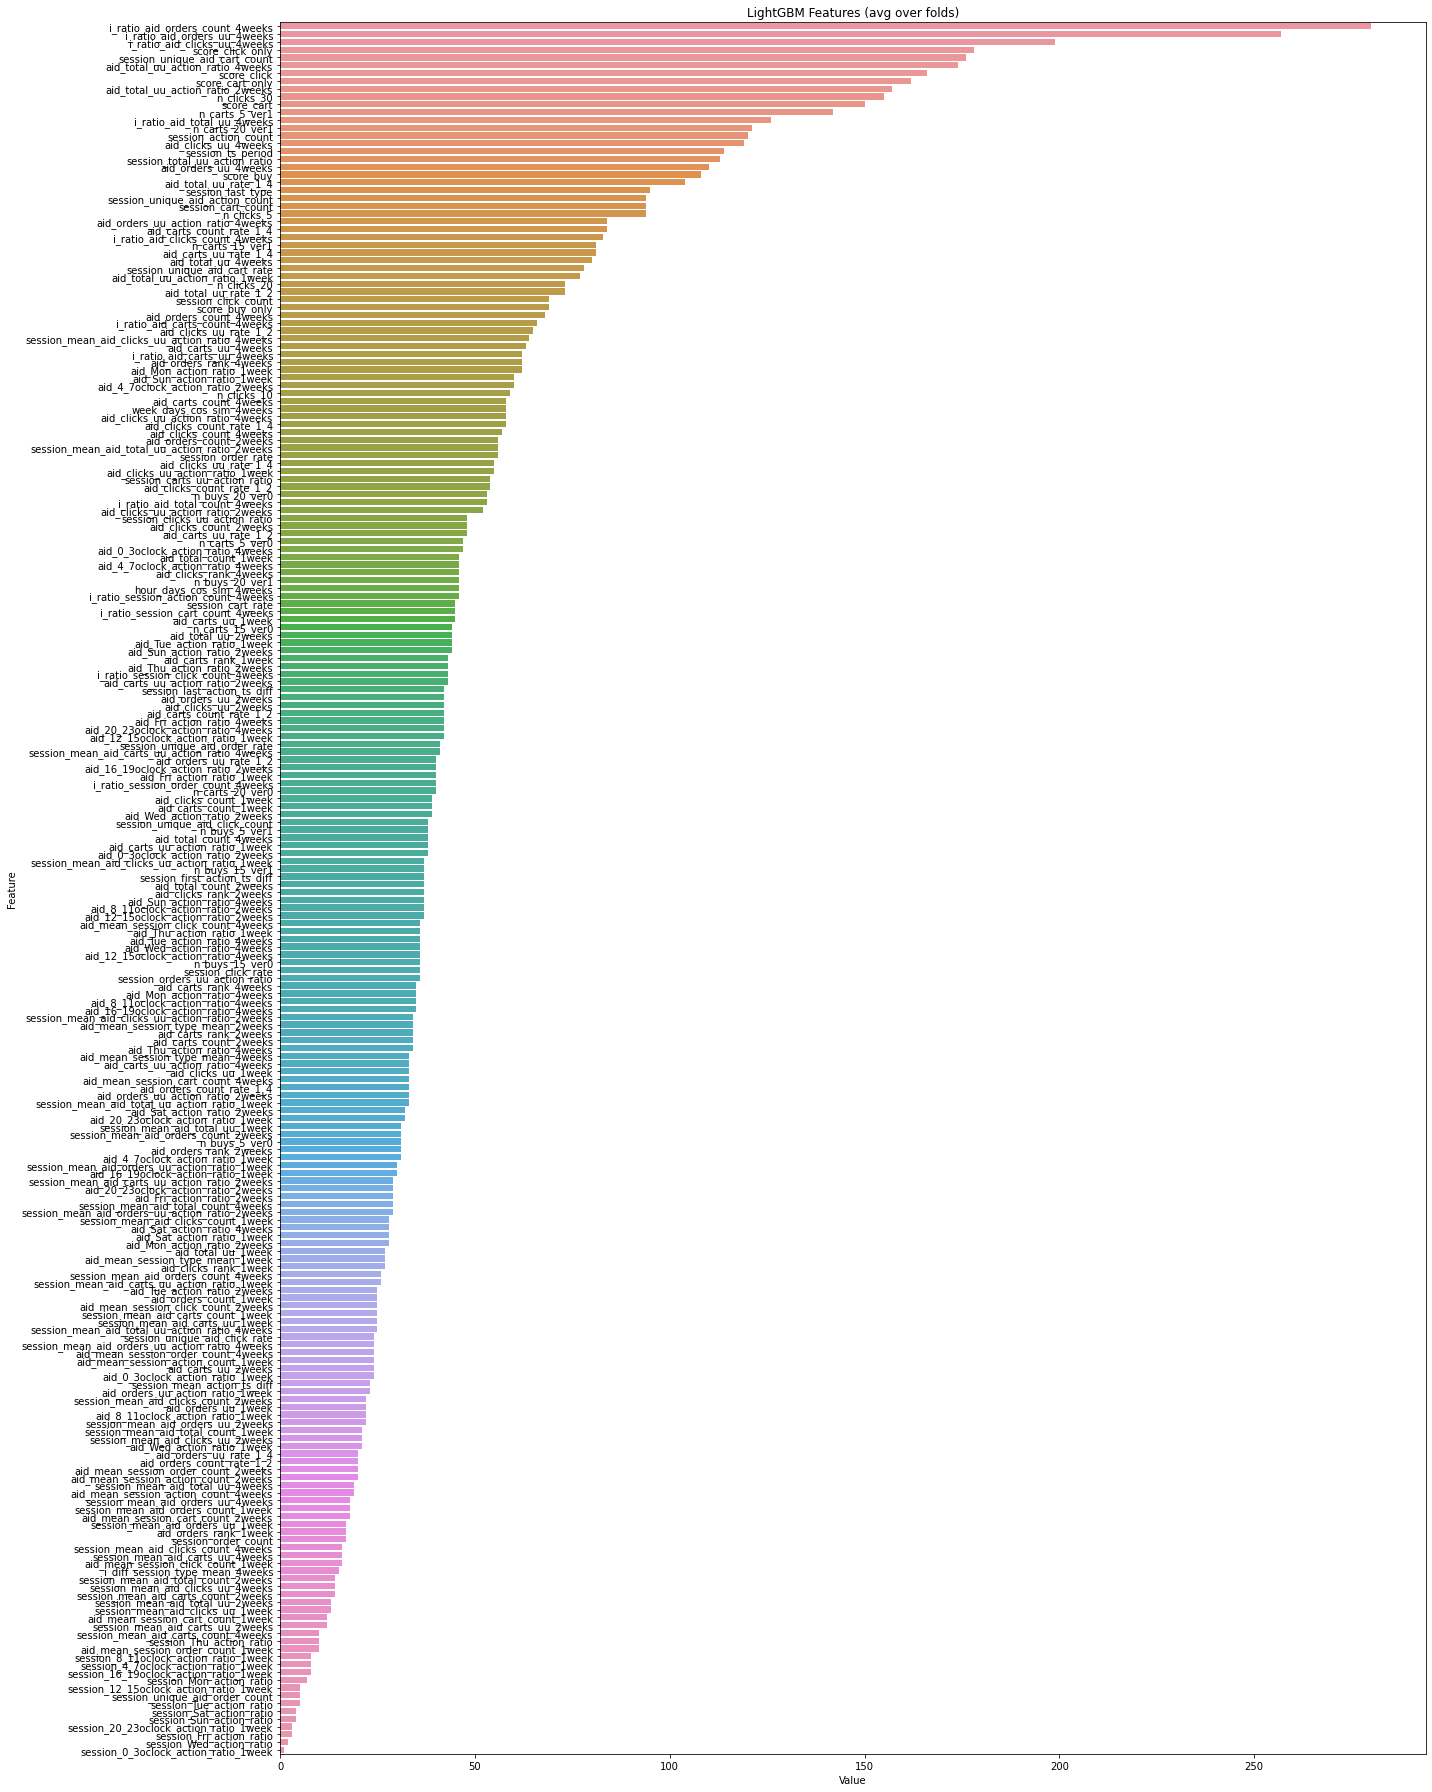

In [13]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp_split = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 25))
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [15]:
feature_imp_split

,Value,Feature
0,1,session_0_3oclock_action_ratio_1week
1,2,session_Wed_action_ratio
2,3,session_20_23oclock_action_ratio_1week
3,3,session_Fri_action_ratio
4,4,session_Sat_action_ratio
5,4,session_Sun_action_ratio
6,5,session_12_15oclock_action_ratio_1week
7,5,session_Tue_action_ratio
8,5,session_unique_aid_order_count
9,7,session_Mon_action_ratio


In [14]:
#feature_imp

,Value,Feature
0,2.064229e+01,session_Wed_action_ratio
1,2.132500e+01,session_0_3oclock_action_ratio_1week
2,2.916805e+01,session_20_23oclock_action_ratio_1week
3,3.856710e+01,session_Fri_action_ratio
4,4.035098e+01,session_Sun_action_ratio
5,4.222973e+01,session_Sat_action_ratio
6,4.665108e+01,session_12_15oclock_action_ratio_1week
7,5.858662e+01,session_Tue_action_ratio
8,8.248687e+01,session_8_11oclock_action_ratio_1week
9,8.477134e+01,session_Mon_action_ratio


In [25]:
#ans_list = []
# 分割してpredictするための準備
Nrow = test.shape[0]
Ndiv = 10
n = int(Nrow // Ndiv) + 1


for target in type_list:
    print('target=', target,'*************')
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    
    # if use stacking method, use differennt model with target prediction features
    if CROSS_TARGET_STACKING:
        if target == 'clicks':
            target_list = ['carts', 'orders']
        elif target == 'carts':
            target_list = ['clicks', 'orders']
        elif target == 'orders':
            target_list = ['carts', 'clicks']
        x_test = add_cross_stacking_feature(test, target_list, min_session, max_session).drop(IGNORE_COL , axis=1)
    else:
        x_test = test.drop(IGNORE_COL , axis=1)
            
    x_test_list = []
    for i in range(Ndiv):
        tmp = x_test.iloc[i*n : (i+1)*n, :]
        x_test_list.append(tmp)
    del x_test
    gc.collect()
    # fold looop 
    for fold in range(n_splits):
        print('fold=', fold)
        if CROSS_TARGET_STACKING:
            model = np.load(f'{base_path}/otto/otto_lgbm_fold{fold}_{target}_stack.pkl', allow_pickle=True)
        else:
            model = np.load(f'{base_path}/otto/otto_lgbm_fold{fold}_{target}.pkl', allow_pickle=True)
            
        test_pred_list = [] 
        for i, v in enumerate(x_test_list):
            print('test pred i=', i)
            tmp = model.predict(v)
            test_pred_list.append(tmp) 

        test_pred = np.concatenate(test_pred_list)
        del test_pred_list, model
        gc.collect()

        # testの場合はfoldの数で割る
        test_predictions += test_pred / n_splits
    
    # dfに変換していったん保存
    test_predictions = pd.DataFrame(test_predictions, columns=["score"])
    #test_predictions.to_parquet(f'{base_path}/otto/test_predictions_{target}.parquet')
    if CROSS_TARGET_STACKING:
        test_predictions.to_csv(f'{base_path}/otto/test_oof_lgbm_{target}_{OUTPUT_SPLIT_NUM}_stack.csv', index = False)
    else:
        test_predictions.to_csv(f'{base_path}/otto/test_oof_lgbm_{target}_{OUTPUT_SPLIT_NUM}.csv', index = False)
    del test_predictions
    gc.collect()

del x_test_list
gc.collect()

target= orders *************
t= carts i= 0
t= carts i= 1
t= carts i= 2
t= carts i= 3
t= clicks i= 0
t= clicks i= 1
t= clicks i= 2
t= clicks i= 3
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9


0

## Load and Merge type

In [36]:
sub_df_list = []

# 今後はこの2つのcolumnsしか使わないので削っておく
test = test[['session', 'aid']].reset_index(drop=True)

for i, t in enumerate(type_list):
    print(i, t)
    if CROSS_TARGET_STACKING:
        score = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_{t}_{OUTPUT_SPLIT_NUM}_stack.csv')
    else:
        score = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_{t}_{OUTPUT_SPLIT_NUM}.csv')
    pred_df = pd.concat([test, score], axis=1)
    # save score
    if CROSS_TARGET_STACKING:
        pred_df.to_parquet(f'{base_path}/otto/test_predictions_{t}_{OUTPUT_SPLIT_NUM}_stack.parquet')
    else:
        pred_df.to_parquet(f'{base_path}/otto/test_predictions_{t}_{OUTPUT_SPLIT_NUM}_.parquet')

    pred_df['aid'] = pred_df['aid'].astype('int32')
    del score
    gc.collect()
    for j in range(session_splits):
        print('splits session: ',j ,' from ' , session_splits_list[j])
        # last loop
        if j == session_splits - 1:
            tmp = pred_df[session_splits_list[j] <= pred_df['session']]
        else:
            tmp = pred_df[(session_splits_list[j] <= pred_df['session']) & (pred_df['session'] < session_splits_list[j+1])]
        tmp['session_type'] = tmp['session'].apply(lambda x: str(x) + f'_{t}')
        tmp = tmp.drop('session',axis=1)
        tmp = tmp.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
        tmp['n'] = tmp.groupby('session_type').cumcount().astype('int16')
        tmp = tmp.loc[tmp.n<20].drop(['n','score'],axis=1)
        tmp = tmp.groupby('session_type')['aid'].apply(list).reset_index()
        tmp['labels'] = tmp['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
        tmp = tmp.drop(['aid'],axis=1)
        sub_df_list.append(tmp)
del tmp, test
gc.collect()

0 orders
splits session:  0  from  12899779
splits session:  1  from  12983368
splits session:  2  from  13066958
splits session:  3  from  13150548
splits session:  4  from  13234138


0

In [37]:
pred_df = pd.concat(sub_df_list)
del sub_df_list
gc.collect()

0

In [38]:
pred_df.to_csv(f"{base_path}/output/otto/test_preds_{OUTPUT_SPLIT_NUM}.csv", index=False)
pred_df.head()

,session_type,labels
0,12899779_orders,59625 731692 1253524 475447 448688 1790770 689...
1,12899780_orders,1142000 736515 582732 973453 487136 1758603 88...
2,12899781_orders,199008 918667 141736 57315 1460571 1836671 194...
3,12899782_orders,740494 987399 889671 779477 127404 1344773 171...
4,12899783_orders,1817895 198385 1729553 294573 255297 607638 18...


In [39]:
pred_df.shape

(104487, 2)

In [40]:
del pred_df
gc.collect()

0